# 亲情关系判别

## 1 数据处理

###  1.1 数据观察

In [1]:
%matplotlib  inline
import  pandas as pd
import numpy as np
from  sklearn import svm

import matplotlib.pylab as plt
import time
# from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional     scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

In [3]:
rel_data=pd.read_csv('MSN/ymdh/mobi_rel_data.csv',index_col=0)

/usr/bin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (2,42,81) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
rel_data.drop(['custorm_id.1','number.1','custorm_id.2','number.2'],axis=1,inplace=True)
used=pd.read_csv('MSN/ymdh/wyd_relative_used_data.csv')
rel_df=pd.merge(rel_data,used,on=['custorm_id','number'])
rel_df.drop(['number','name'],axis=1,inplace=True)
rel_df.set_index('custorm_id',inplace=True)

In [14]:
used.head(3)

,custorm_id,number,name,is_rel
0,3823639,15159388798,太上皇,1
1,3074006,14718568341,老妈子,1
2,6228794,15632958237,媳妇,1


In [35]:
rel_df.head(2)

,total_frequency,total_duration,avg_duration,max_duration,min_duration,coef_var,income_total_duration,outgo_total_duration,income_total_frequency,outgo_total_frequency,...,workday3_engegament_ratio,workday3_avg_time,workday3_time_ratio,workday3_call_cnt_ratio,workday3_income_time_ratio,workday3ougo_time_ratio,workday3_income_cnt_ratio,workday3_ougo_cnt_ratio,week_work_ratio,is_rel
custorm_id,,,,,,,,,,,,,,,,,,,,,
1000064,39,3023.0,77.512821,371.0,12.0,1.135243,953.0,2070.0,14,25,...,0.75063,44.111111,0.355416,0.60,0.222023,0.133393,0.266667,0.333333,2.831432,0
1000092,21,1413.0,67.285714,153.0,12.0,0.520324,872.0,541.0,15,6,...,NaN,50.666667,0.652361,0.75,0.652361,NaN,0.750000,0.000000,0.492080,0


### 1.2  异常值处理
- 通过观察数据分布的形式，将极值点去掉，最大程度上使得数据均匀分布

In [174]:
cond=(rel_df.outgo_time_ratio<1.0)&(rel_df.month_avg_income2avg<2.0)

workday2_income_cnt_ratio


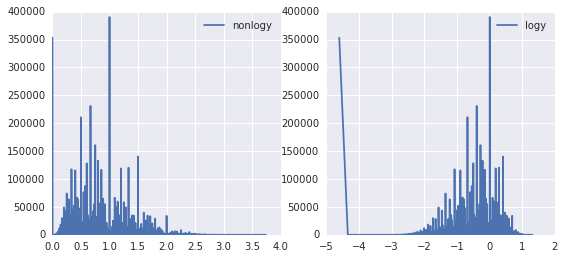

In [166]:
num=115
label=rel_df.columns[num]  
print label
fig,(ax1,ax2)=plt.subplots(ncols=2,nrows=1,figsize=(9,4))

s1=np.log(rel_df[label]+0.01).astype('float').value_counts().sort_index().dropna()
ax2.plot(s1.index,s1.values,label='logy')
s2=rel_df[label].astype('float').value_counts().sort_index().dropna()
ax1.plot(s2.index,s2.values,label='nonlogy')
ax1.legend(loc=1)
ax2.legend(loc=1)

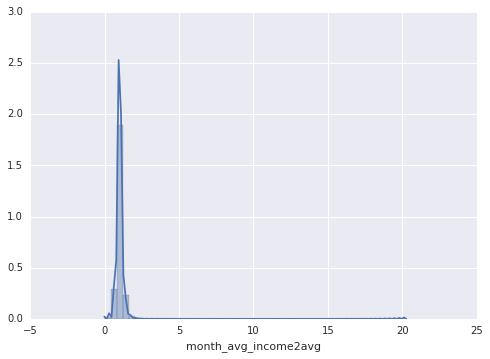

In [135]:
import seaborn as sns
sns.distplot(rel_df[label].dropna())

In [138]:
rel_df[rel_df.month_avg_income2avg>2].shape

(29279, 133)

In [141]:
rel_df.month_avg_income2avg.quantile(0.95)

1.3412107515525

month_avg_income2avg


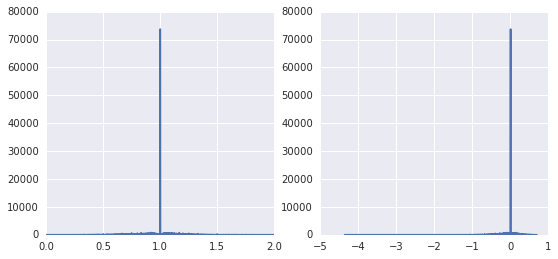

In [151]:
print label
fig,(ax1,ax2)=plt.subplots(ncols=2,nrows=1,figsize=(9,4))

s1=np.log(rel_df[cond][label]+0.01).astype('float').value_counts().sort_index().dropna()
ax2.plot(s1.index,s1.values)
s2=rel_df[cond][label].astype('float').value_counts().sort_index().dropna()
ax1.plot(s2.index,s2.values)

In [176]:
## 异常值处理
rel_df=rel_df[cond]  
## 缺失值处理
rel_df.fillna(0.0,inplace=True)
## 对数转换
# X_rel=np.log(rel_df.ix[:,:-1]+0.01)

### 1.3 不平衡数据处理

In [3]:
rel_df=pd.read_csv('MSN/ymdh/proce_data/mobi_train_data.csv',index_col=0)
target=rel_df.is_rel

## 对数变化、标准化
Maxmin=lambda df:(df-df.min())/(df.max()-df.min())
rel_df=Maxmin(np.log(rel_df.ix[:,:-1].fillna(0.0)+0.01))
rel_df['is_rel']=target
rel_num=rel_df[rel_df.is_rel==1].shape[0]
unrel_num=rel_df[rel_df.is_rel==0].shape[0]
## 欠采样
sampler = np.random.permutation(unrel_num)[:rel_num]
rel_df=pd.concat([rel_df[rel_df.is_rel==0].take(sampler),rel_df[rel_df.is_rel==1]],axis=0)

## 重采样
# sampler = np.random.randint(0,rel_num,size=unrel_num)
# rel_df=pd.concat([rel_df[rel_df.is_rel==1].take(sampler),rel_df[rel_df.is_rel==0]],axis=0)

# unrel_df=rel_df[rel_df.is_rel==0]
print rel_num,unrel_num

2068888 6335996


In [4]:
rel_df.shape

(4137776, 133)

In [5]:
rel_df.to_csv('MSN/ymdh/proce_data/mobi_under_proc_data.csv')

##  三 、模型训练

### 3.1 LR

In [3]:
from sklearn.linear_model import LogisticRegression 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, auc,roc_auc_score,precision_score,accuracy_score,f1_score,recall_score,auc
import gc
rel_df=pd.read_csv('MSN/ymdh/proce_data/mobi_under_proc_data.csv',index_col=0)
target=rel_df.is_rel
rel_df=rel_df.ix[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(rel_df, target)
del target
del rel_df
gc.collect()

55

In [4]:
clf = LogisticRegression()  # 使用类，参数全是默认的  
clf.fit(X_train, y_train)  # 训练数据来学习，不需要返回值
y_pred=clf.predict(X_test)
print 'auc:',roc_auc_score(y_test, y_pred)
print 'precision:',precision_score(y_test,y_pred)
print 'accuracy:',accuracy_score(y_test,y_pred)
print 'f1:',f1_score(y_test,y_pred)
print 'recall:',recall_score(y_test,y_pred)

auc: 0.661403605158
precision: 0.664836758122
accuracy: 0.661428748197
f1: 0.656534978254
recall: 0.648437969157


In [ ]:
from sklearn import svm
k=['rbf', 'linear','poly','sigmoid']
c= range(1,10)
g=np.arange(1e-4,1e-2,0.001)
g=g.tolist()
param_grid=dict(kernel=k, C=c, gamma=g)
print param_grid

svr=svm.SVC()
grid = GridSearchCV(svr, param_grid, cv=5,scoring='accuracy')
grid.fit(X_train, y_train)

# y_pre=clf.predict(X_test)
# print roc_auc_score(y_test, y_pred)
# print precision_score(y_test,y_pred)
# print accuracy_score(y_test,y_pred)
# print f1_score(y_test,y_pred)
# print recall_score(y_test,y_pred)

print("Grid scores on development set:")
print grid.grid_scores_  

print("Best parameters set found on development set:")
print(grid.best_params_)
print("Grid best score:")

print (grid.best_score_)
# create a list of the mean scores only
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print grid_mean_scores

In [ ]:
from sklearn import svm

svr=svm.SVC()
svr.fit(X_train, y_train)

y_pred=svr.predict(X_test)
print 'auc:',roc_auc_score(y_test, y_pred)
print 'precision:',precision_score(y_test,y_pred)
print 'accuracy:',accuracy_score(y_test,y_pred)
print 'f1:',f1_score(y_test,y_pred)
print 'recall:',recall_score(y_test,y_pred)